### Import and Setting

In [1]:
import pandas as pd
import numpy as np

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from bayes_opt import BayesianOptimization

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('bmh')
plt.rcParams.update({'font.size': 14})

import warnings
warnings.filterwarnings('ignore')

SEED = 2004


In [2]:
X_train = pd.read_csv('data/X_train.csv')
X_test = pd.read_csv('data/X_test.csv')
y_train = pd.read_csv('data/y_train.csv')
y_test = pd.read_csv('data/y_test.csv')

### Correlation Matrix

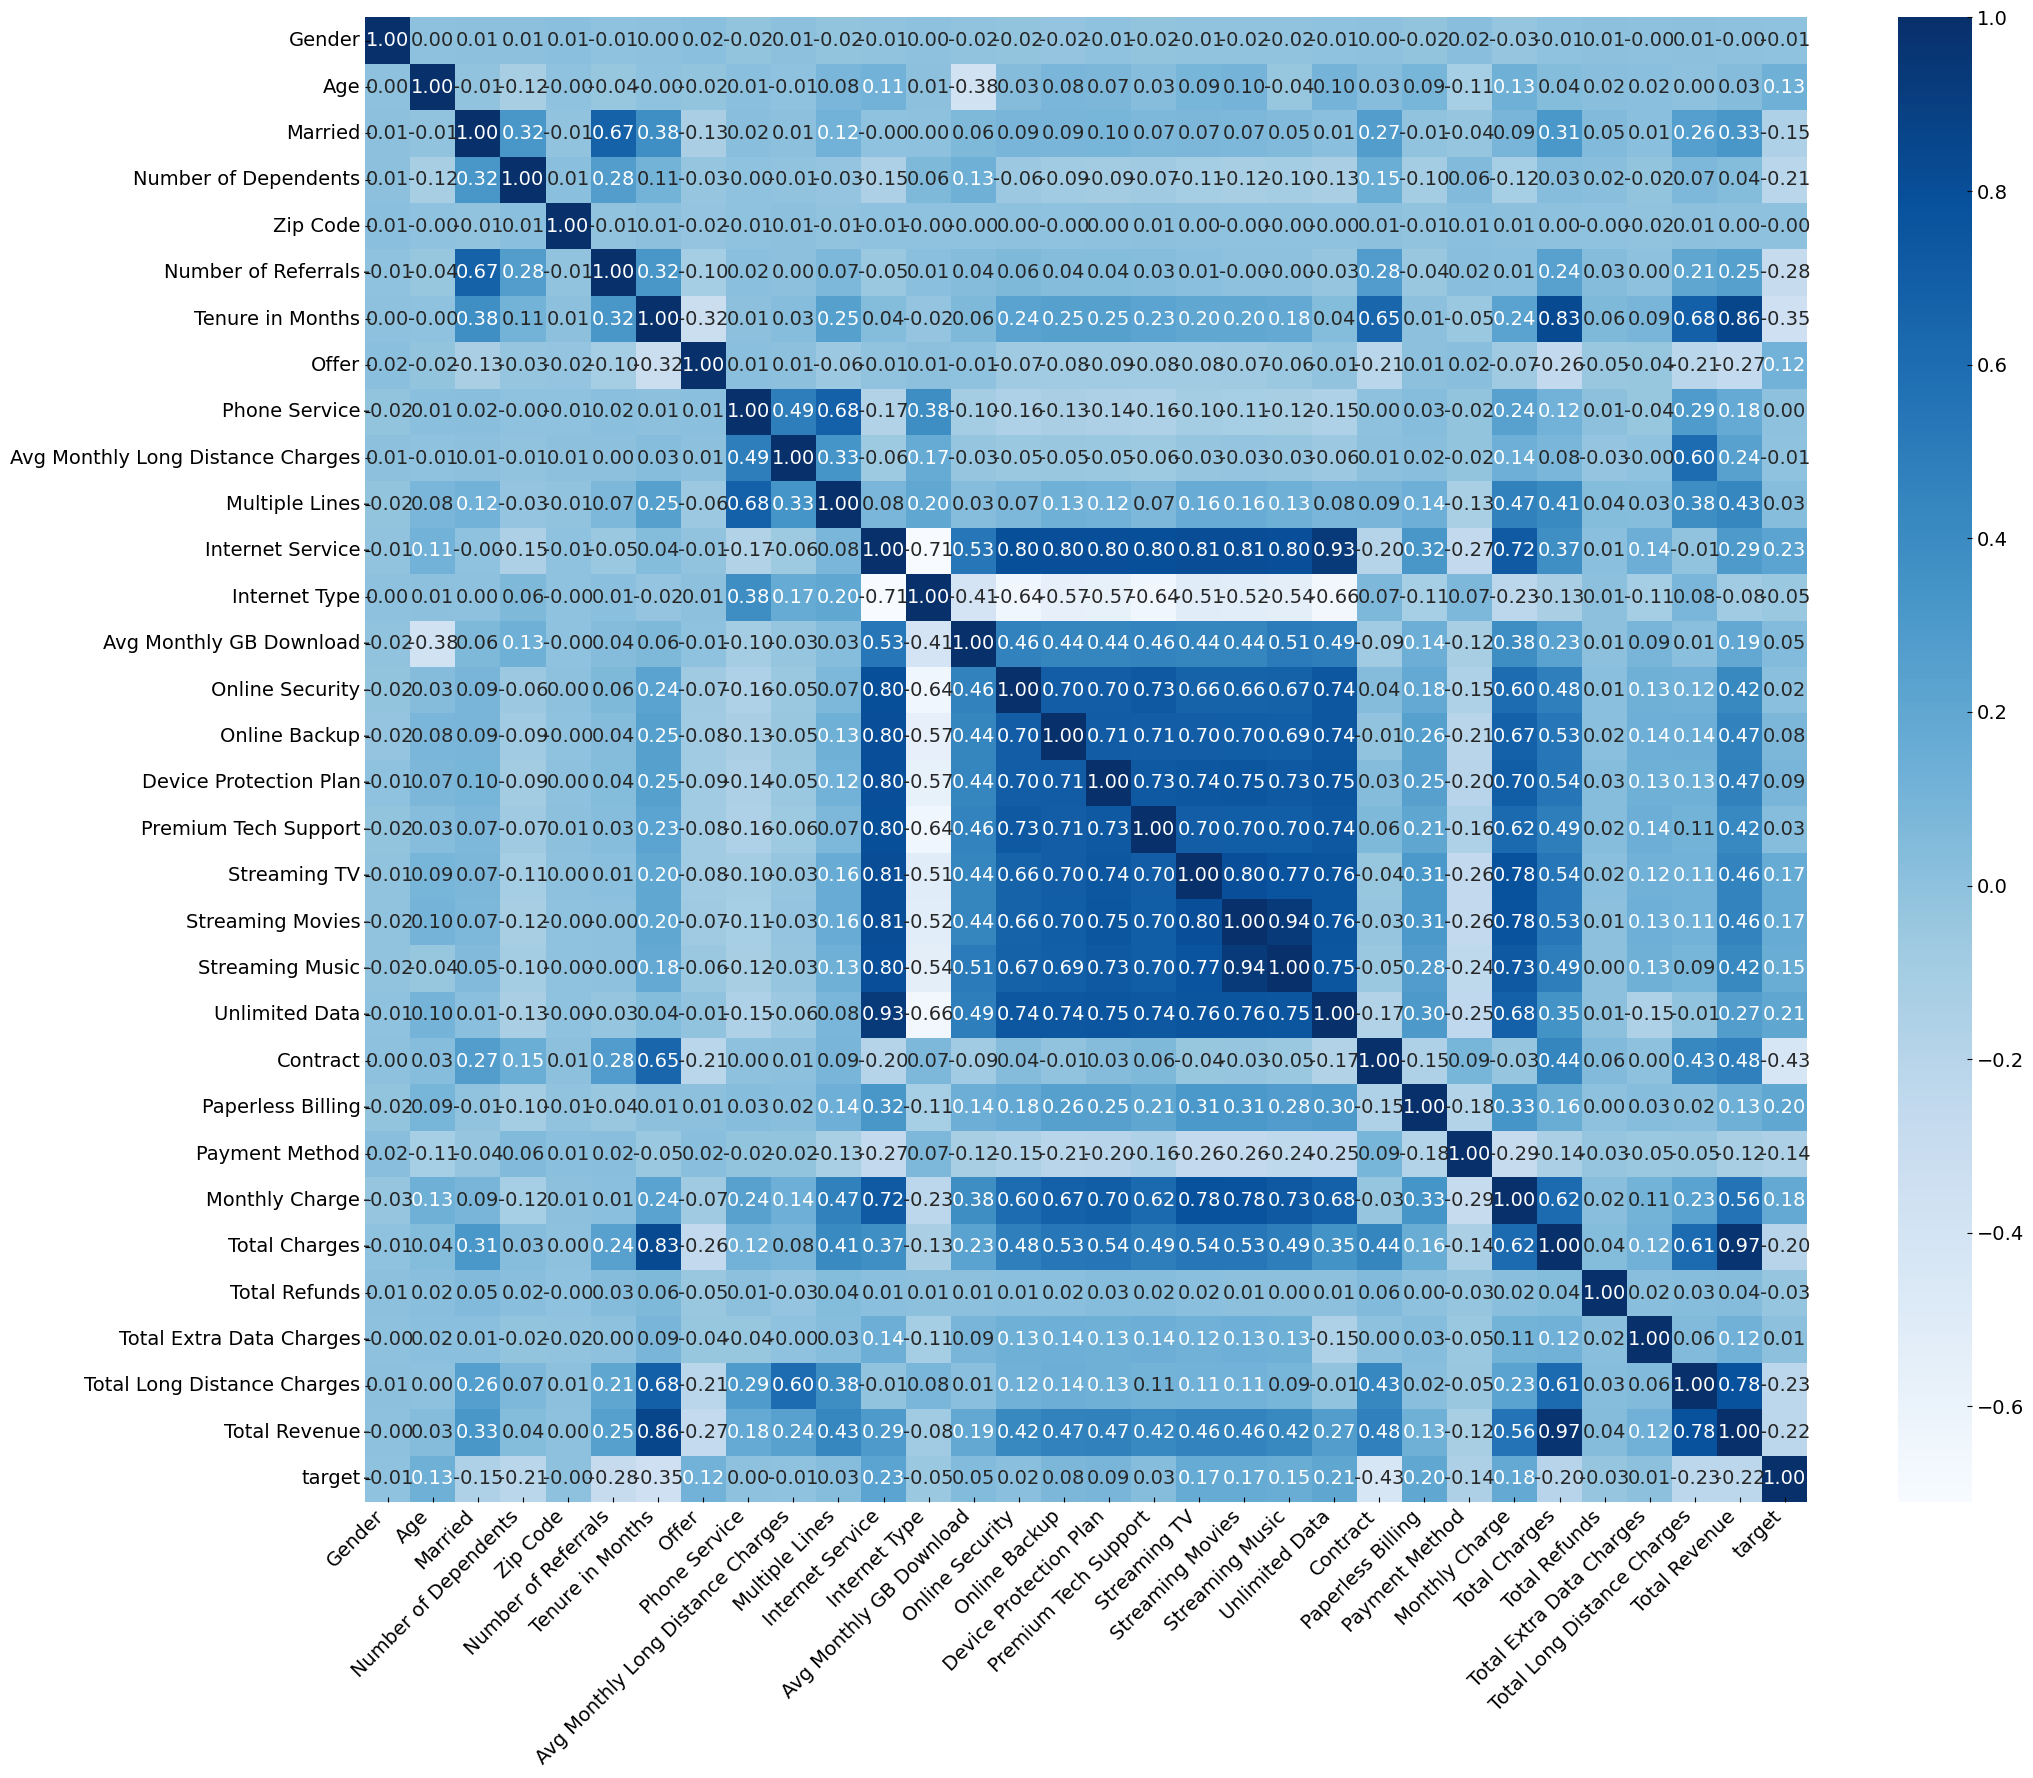

In [3]:
# add y_train to X_train for correlation analysis
X_train_corr = X_train.copy()
X_train_corr['target'] = y_train

corr_m = X_train_corr.corr()
plt.figure(figsize=(22, 18))
plt.grid(False)
sns.heatmap(corr_m, annot=True, annot_kws={'size': 14}, cmap='Blues', fmt=".2f")
plt.tick_params(axis='both', labelsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(ha='right')
plt.tight_layout()


In [4]:
X_train.columns

Index(['Gender', 'Age', 'Married', 'Number of Dependents', 'Zip Code',
       'Number of Referrals', 'Tenure in Months', 'Offer', 'Phone Service',
       'Avg Monthly Long Distance Charges', 'Multiple Lines',
       'Internet Service', 'Internet Type', 'Avg Monthly GB Download',
       'Online Security', 'Online Backup', 'Device Protection Plan',
       'Premium Tech Support', 'Streaming TV', 'Streaming Movies',
       'Streaming Music', 'Unlimited Data', 'Contract', 'Paperless Billing',
       'Payment Method', 'Monthly Charge', 'Total Charges', 'Total Refunds',
       'Total Extra Data Charges', 'Total Long Distance Charges',
       'Total Revenue'],
      dtype='object')

In [5]:
X_train.shape

(5634, 31)

In [6]:
drop_cols = ['Total Charges', 'Total Revenue',
            'Online Security', 'Online Backup', 'Device Protection Plan', 'Premium Tech Support', 
            'Streaming TV', 'Streaming Movies', 'Streaming Music', 
            'Unlimited Data']
X_train = X_train.drop(drop_cols, axis=1)
X_train.shape

(5634, 21)

In [7]:
X_test = X_test.drop(drop_cols, axis=1)
X_test.shape

(1409, 21)

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5]),
 [Text(0, 0.5, 'Gender'),
  Text(0, 1.5, 'Age'),
  Text(0, 2.5, 'Married'),
  Text(0, 3.5, 'Number of Dependents'),
  Text(0, 4.5, 'Zip Code'),
  Text(0, 5.5, 'Number of Referrals'),
  Text(0, 6.5, 'Tenure in Months'),
  Text(0, 7.5, 'Offer'),
  Text(0, 8.5, 'Phone Service'),
  Text(0, 9.5, 'Avg Monthly Long Distance Charges'),
  Text(0, 10.5, 'Multiple Lines'),
  Text(0, 11.5, 'Internet Service'),
  Text(0, 12.5, 'Internet Type'),
  Text(0, 13.5, 'Avg Monthly GB Download'),
  Text(0, 14.5, 'Contract'),
  Text(0, 15.5, 'Paperless Billing'),
  Text(0, 16.5, 'Payment Method'),
  Text(0, 17.5, 'Monthly Charge'),
  Text(0, 18.5, 'Total Refunds'),
  Text(0, 19.5, 'Total Extra Data Charges'),
  Text(0, 20.5, 'Total Long Distance Charges')])

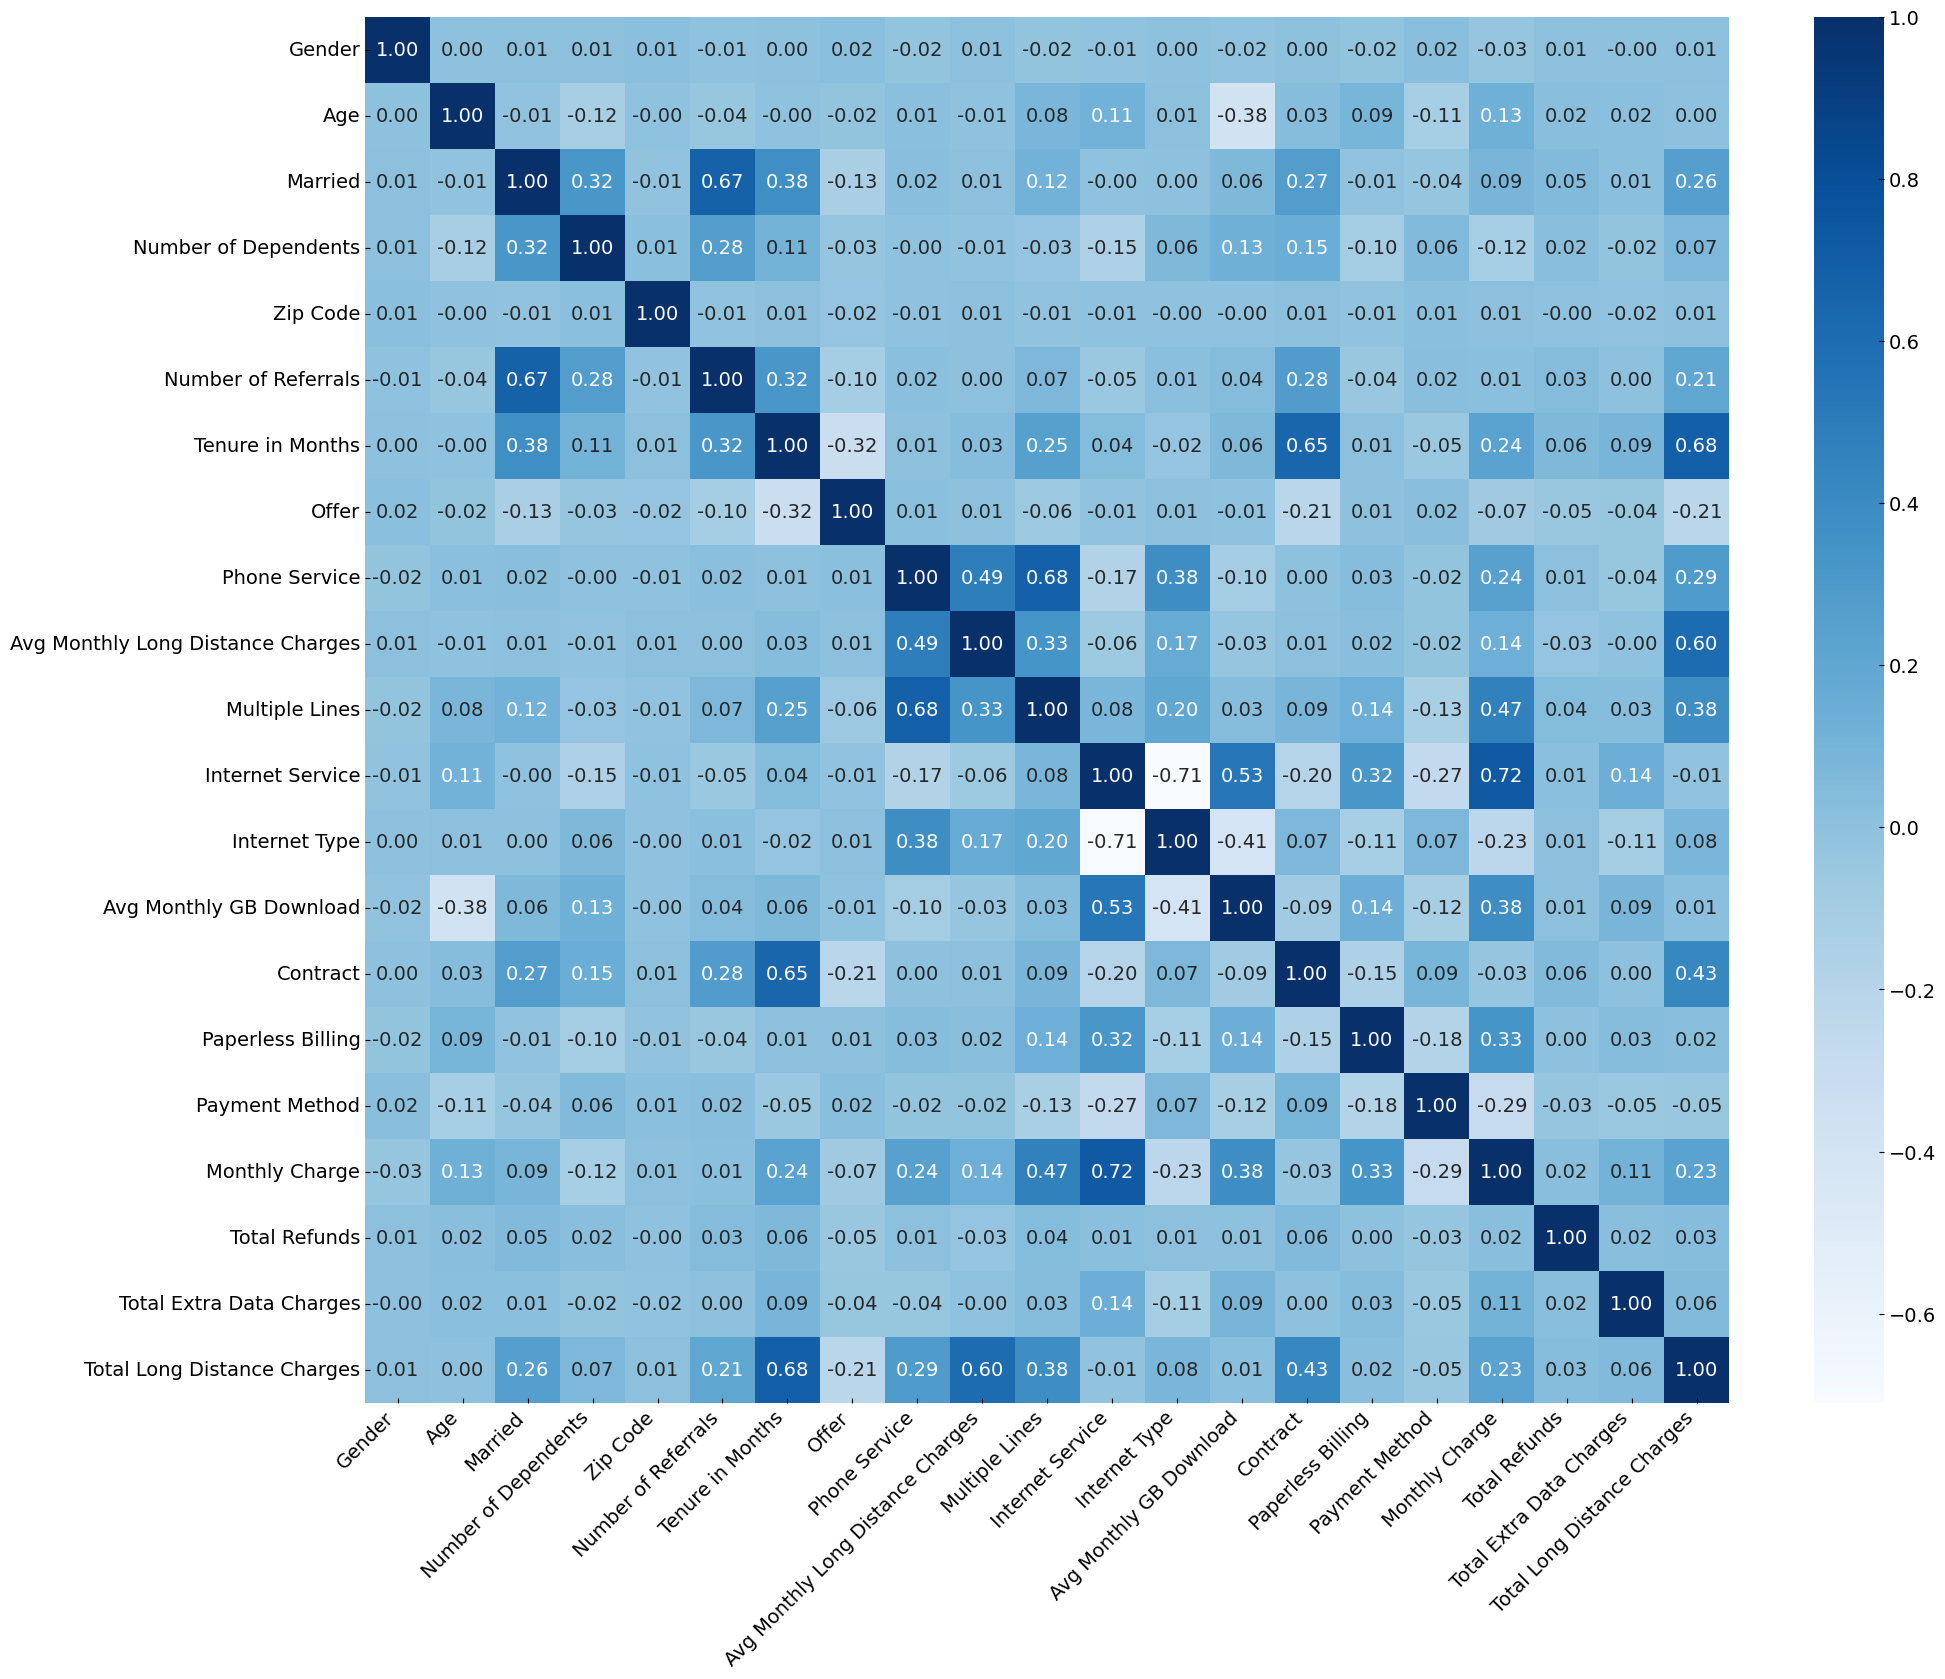

In [8]:
corr = X_train.corr()
plt.figure(figsize=(22, 18))
plt.grid(False)
sns.heatmap(corr, annot=True, annot_kws={'size': 14}, cmap='Blues', fmt=".2f")
plt.tick_params(axis='both', labelsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(ha='right')


## XGBoost

In [9]:
results = {
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1': [],
    'AUC': []
}

In [10]:
def evaluate_metrics(name, y_test, y_pred, y_pred_proba):

    auc = roc_auc_score(y_test, y_pred_proba)
    
    results['Model'].append(name)
    results['Accuracy'].append(accuracy_score(y_test, y_pred))
    results['Precision'].append(precision_score(y_test, y_pred))
    results['Recall'].append(recall_score(y_test, y_pred))
    results['F1'].append(f1_score(y_test, y_pred))
    results['AUC'].append(auc)

    print('AUC: ', auc)
    print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred))
    print('Classification Report: \n', classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred, normalize='true')
    plt.figure(figsize=(3, 3))
    sns.heatmap(cm, annot=True, fmt='.3f', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{name} CM')
    plt.grid(False)
    plt.show()

    return auc

AUC:  0.9080446407812137
Confusion Matrix: 
 [[917 118]
 [ 96 278]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.91      0.89      0.90      1035
           1       0.70      0.74      0.72       374

    accuracy                           0.85      1409
   macro avg       0.80      0.81      0.81      1409
weighted avg       0.85      0.85      0.85      1409



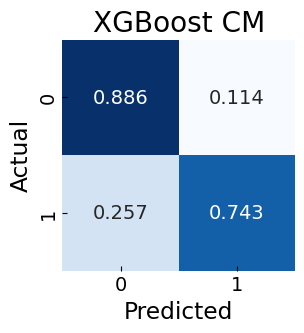

In [11]:
scale_pos_w = y_train.value_counts()[0] / y_train.value_counts()[1]

params = {
    'scale_pos_weight': scale_pos_w,
    'random_state': SEED, 
}

xgb = XGBClassifier(**params)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
y_pred_proba_xgb = xgb.predict_proba(X_test)[:,1]

auc_xgb = evaluate_metrics('XGBoost', y_test, y_pred_xgb, y_pred_proba_xgb)

### Bayesian Optimization

In [12]:
def xgb_cv(n_estimators, max_depth, gamma, min_child_weight, subsample, colsample_bytree, reg_lambda, learning_rate):
    params = {
        'n_estimators': int(n_estimators),
        'max_depth': int(max_depth),
        'gamma': max(gamma, 0),
        'min_child_weight': min_child_weight,
        'subsample': max(subsample, 0.1),
        'colsample_bytree': max(colsample_bytree, 0.1),
        'reg_lambda': max(reg_lambda, 0),
        'learning_rate': max(learning_rate, 0.0001),
        'scale_pos_weight': scale_pos_w,
        'random_state': SEED
    }
    xgb_model = XGBClassifier(**params)
    cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=3, scoring='roc_auc')
    return np.mean(cv_scores)

pbounds = {
    'n_estimators': (100, 1000),
    'max_depth': (3, 10),
    'gamma': (0.001, 0.1),
    'min_child_weight': (1, 10),
    'subsample': (0.5, 1.0),
    'colsample_bytree': (0.5, 1.0),
    'reg_lambda': (0.001, 0.1),
    'learning_rate': (0.0001, 0.01)
}

optimizer = BayesianOptimization(f=xgb_cv, pbounds=pbounds, random_state=SEED)
optimizer.maximize(init_points=10, n_iter=50)


|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------
| 1         | 0.9081    | 0.7939    | 0.08064   | 0.004756  | 6.4       | 7.829     | 812.7     | 0.05905   | 0.986     |
| 2         | 0.9027    | 0.7816    | 0.008047  | 0.004248  | 6.099     | 5.434     | 229.7     | 0.01622   | 0.8303    |
| 3         | 0.9073    | 0.605     | 0.007639  | 0.009668  | 9.481     | 8.404     | 733.8     | 0.09969   | 0.9914    |
| 4         | 0.8964    | 0.8666    | 0.09469   | 0.001478  | 5.011     | 8.557     | 379.5     | 0.07298   | 0.8289    |
| 5         | 0.9069    | 0.9732    | 0.05291   | 0.004359  | 7.573     | 3.475     | 951.2     | 0.03639   | 0.7116    |
| 6         | 0.8963    | 0.8561    | 0.01635   | 0.0006327 | 8.671     | 2.75      | 223.2     | 0.06954   | 0.9261    |
| 7         | 0.9047    

In [13]:
best_params = optimizer.max['params']
best_params['n_estimators'] = int(best_params['n_estimators'])
best_params['max_depth'] = int(best_params['max_depth'])
print("Best parameters found: ", best_params)


Best parameters found:  {'colsample_bytree': np.float64(0.6624155096343476), 'gamma': np.float64(0.1), 'learning_rate': np.float64(0.01), 'max_depth': 4, 'min_child_weight': np.float64(10.0), 'n_estimators': 800, 'reg_lambda': np.float64(0.1), 'subsample': np.float64(1.0)}


In [14]:
best_params['scale_pos_weight'] = scale_pos_w
best_params['random_state'] = SEED 
print("Best parameters found: ", best_params)


Best parameters found:  {'colsample_bytree': np.float64(0.6624155096343476), 'gamma': np.float64(0.1), 'learning_rate': np.float64(0.01), 'max_depth': 4, 'min_child_weight': np.float64(10.0), 'n_estimators': 800, 'reg_lambda': np.float64(0.1), 'subsample': np.float64(1.0), 'scale_pos_weight': np.float64(2.768561872909699), 'random_state': 2004}


AUC:  0.9184091554935545
Confusion Matrix: 
 [[839 196]
 [ 50 324]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.94      0.81      0.87      1035
           1       0.62      0.87      0.72       374

    accuracy                           0.83      1409
   macro avg       0.78      0.84      0.80      1409
weighted avg       0.86      0.83      0.83      1409



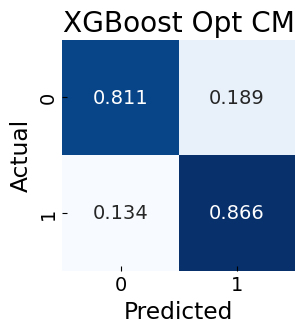

In [15]:
xgb = XGBClassifier(**best_params)
xgb.fit(X_train, y_train)
y_pred_xgb_opt = xgb.predict(X_test)
y_pred_proba_xgb_opt = xgb.predict_proba(X_test)[:,1]

auc_xgb_opt = evaluate_metrics('XGBoost Opt', y_test, y_pred_xgb_opt, y_pred_proba_xgb_opt)

### Feature Importances

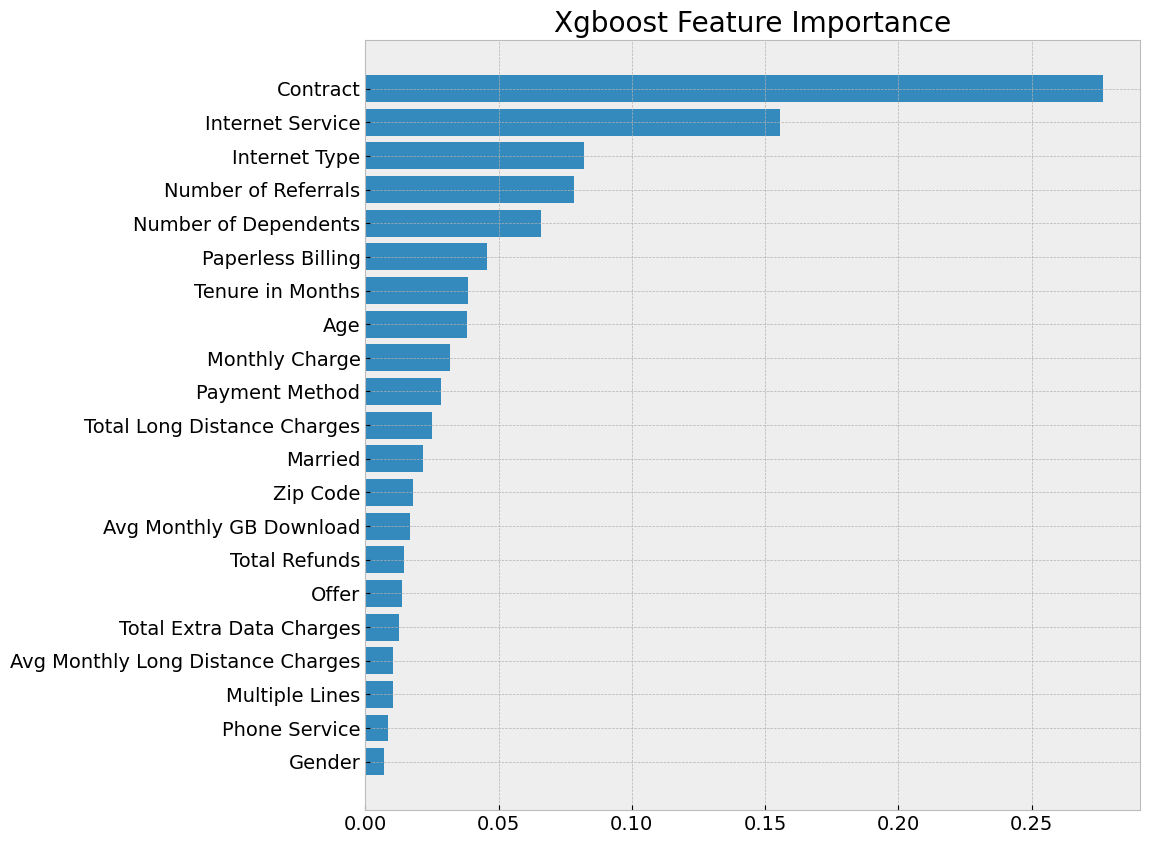

In [16]:
sorted_idx = xgb.feature_importances_.argsort()
plt.figure(figsize=(10, 10))
plt.barh(X_train.columns[sorted_idx], xgb.feature_importances_[sorted_idx])
plt.title("Xgboost Feature Importance")
plt.show()

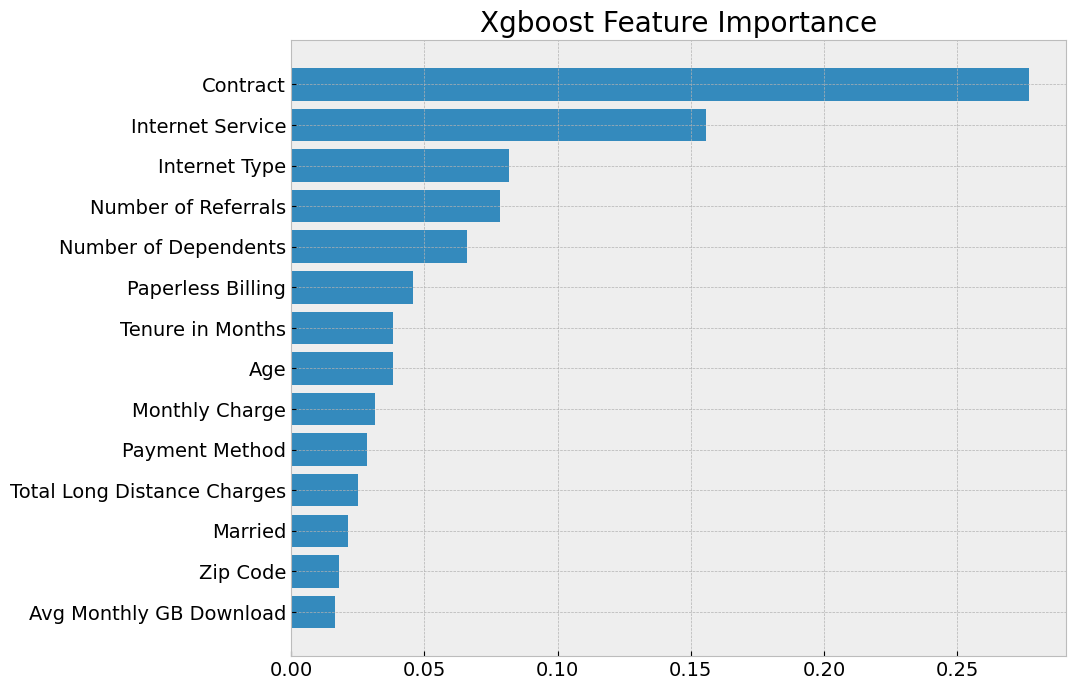

In [17]:
high_imp_feats = xgb.feature_importances_ > 0.015
filtered_idx = sorted_idx[high_imp_feats[sorted_idx]]

plt.figure(figsize=(10, 8))
plt.barh(X_train.columns[filtered_idx], xgb.feature_importances_[filtered_idx])
plt.title("Xgboost Feature Importance")
plt.show()

## Light GBM

AUC:  0.9141749980624659
Confusion Matrix: 
 [[880 155]
 [ 72 302]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.92      0.85      0.89      1035
           1       0.66      0.81      0.73       374

    accuracy                           0.84      1409
   macro avg       0.79      0.83      0.81      1409
weighted avg       0.85      0.84      0.84      1409



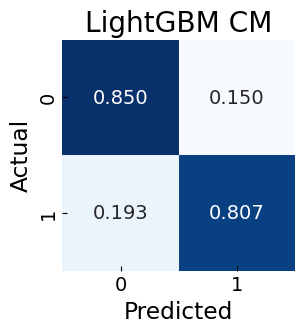

In [18]:
params = {
    'class_weight': 'balanced',
    'random_state': SEED,
    'verbose': -1
}

lgbm = LGBMClassifier(**params)
lgbm.fit(X_train, y_train)
y_pred_lgbm = lgbm.predict(X_test)
y_pred_proba_lgbm = lgbm.predict_proba(X_test)[:,1]

auc_lgbm = evaluate_metrics('LightGBM', y_test, y_pred_lgbm, y_pred_proba_lgbm)


### Bayesian Optimization

In [19]:
def lgbm_cv(n_estimators, max_depth, min_child_weight, subsample, colsample_bytree, reg_lambda, learning_rate):
    params = {
        'n_estimators': int(n_estimators),
        'max_depth': int(max_depth),
        'min_child_weight': min_child_weight,
        'subsample': max(subsample, 0.1),
        'colsample_bytree': max(colsample_bytree, 0.1),
        'reg_lambda': max(reg_lambda, 0),
        'learning_rate': max(learning_rate, 0.0001),
        'class_weight': 'balanced',
        'random_state': SEED,
        'verbose': -1
    }
    lgbm_model = LGBMClassifier(**params)
    cv_scores = cross_val_score(lgbm_model, X_train, y_train, cv=3, scoring='roc_auc')
    return np.mean(cv_scores)

pbounds = {
    'n_estimators': (100, 1000),
    'max_depth': (3, 10),
    'min_child_weight': (1, 10),
    'subsample': (0.5, 1.0),
    'colsample_bytree': (0.5, 1.0),
    'reg_lambda': (0.001, 0.1),
    'learning_rate': (0.0001, 0.01)
}

optimizer = BayesianOptimization(f=lgbm_cv, pbounds=pbounds, random_state=SEED)
optimizer.maximize(init_points=10, n_iter=50)

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | n_esti... | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------
| 1         | 0.9087    | 0.7939    | 0.008064  | 6.292     | 5.371     | 782.9     | 0.0794    | 0.7932    |
| 2         | 0.8985    | 0.986     | 0.005676  | 3.498     | 4.771     | 498.5     | 0.04977   | 0.572     |
| 3         | 0.9095    | 0.5769    | 0.006639  | 4.471     | 1.604     | 969.8     | 0.09267   | 0.9113    |
| 4         | 0.9055    | 0.8521    | 0.009969  | 9.879     | 7.599     | 951.7     | 0.01478   | 0.6437    |
| 5         | 0.9069    | 0.9198    | 0.003174  | 8.089     | 6.92      | 951.8     | 0.05291   | 0.7151    |
| 6         | 0.9047    | 0.8267    | 0.002822  | 9.621     | 4.218     | 480.9     | 0.07152   | 0.5775    |
| 7         | 0.9099    | 0.5269    | 0.00812   | 4.361     | 2.232     | 723.1     | 0.08536   | 0.8522    |
| 8       

In [20]:
best_params = optimizer.max['params']
best_params['n_estimators'] = int(best_params['n_estimators'])
best_params['max_depth'] = int(best_params['max_depth'])
print("Best parameters found: ", best_params)

Best parameters found:  {'colsample_bytree': np.float64(0.5), 'learning_rate': np.float64(0.01), 'max_depth': 4, 'min_child_weight': np.float64(4.460860107740181), 'n_estimators': 966, 'reg_lambda': np.float64(0.1), 'subsample': np.float64(0.5)}


In [21]:
best_params['class_weight'] = 'balanced'
best_params['random_state'] = SEED 
best_params['verbose'] = -1
print("Best parameters found: ", best_params)

Best parameters found:  {'colsample_bytree': np.float64(0.5), 'learning_rate': np.float64(0.01), 'max_depth': 4, 'min_child_weight': np.float64(4.460860107740181), 'n_estimators': 966, 'reg_lambda': np.float64(0.1), 'subsample': np.float64(0.5), 'class_weight': 'balanced', 'random_state': 2004, 'verbose': -1}


AUC:  0.9189800821514376
Confusion Matrix: 
 [[845 190]
 [ 53 321]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.94      0.82      0.87      1035
           1       0.63      0.86      0.73       374

    accuracy                           0.83      1409
   macro avg       0.78      0.84      0.80      1409
weighted avg       0.86      0.83      0.83      1409



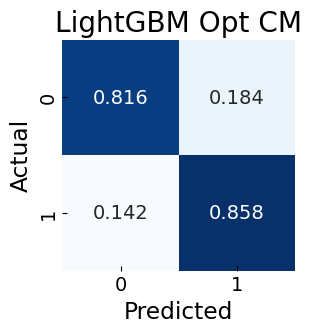

In [22]:
lgbm = LGBMClassifier(**best_params)
lgbm.fit(X_train, y_train)
y_pred_lgbm_opt = lgbm.predict(X_test)
y_pred_proba_lgbm_opt = lgbm.predict_proba(X_test)[:,1]

auc_lgbm_opt = evaluate_metrics('LightGBM Opt', y_test, y_pred_lgbm_opt, y_pred_proba_lgbm_opt)

### Feature Importances

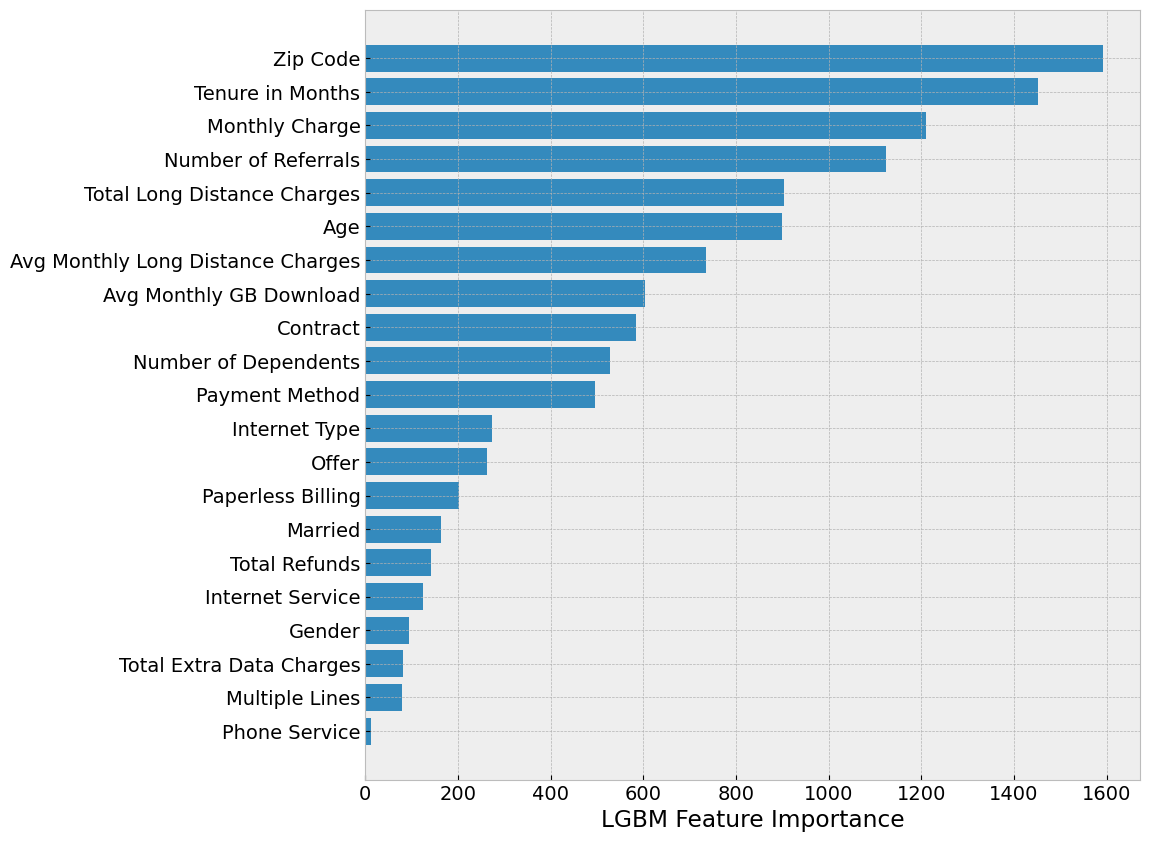

In [23]:
sorted_idx = lgbm.feature_importances_.argsort()
plt.figure(figsize=(10, 10))
plt.barh(X_train.columns[sorted_idx], lgbm.feature_importances_[sorted_idx])
plt.xlabel("LGBM Feature Importance")
plt.show()


In [24]:
feature_importances = pd.DataFrame(lgbm.feature_importances_, index=X_train.columns, columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
Zip Code,1593
Tenure in Months,1452
Monthly Charge,1210
Number of Referrals,1123
Total Long Distance Charges,903
Age,900
Avg Monthly Long Distance Charges,735
Avg Monthly GB Download,604
Contract,584
Number of Dependents,529


<Axes: title={'center': 'Feature Importances'}>

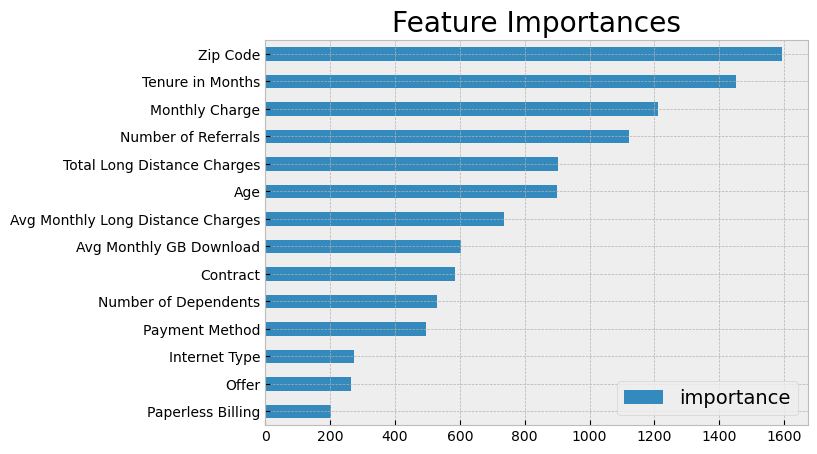

In [25]:
feature_importances = feature_importances.sort_values('importance', ascending=True)
feature_importances[feature_importances['importance'] > 200].plot(kind='barh', title='Feature Importances', style='bmh', fontsize=10, figsize=(7, 5))

## Results

### ROC Curve

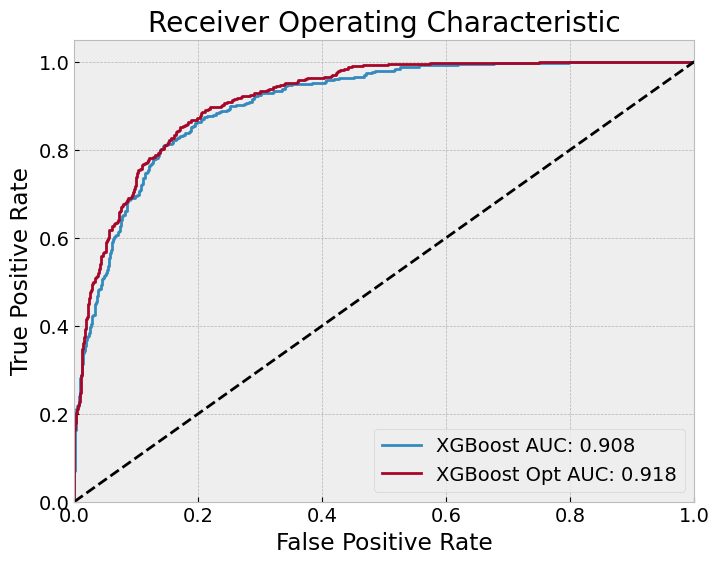

In [27]:
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)
fpr_xgb_opt, tpr_xgb_opt, _ = roc_curve(y_test, y_pred_proba_xgb_opt)
fpr_lgbm, tpr_lgbm, _ = roc_curve(y_test, y_pred_proba_lgbm)
fpr_lgbm_opt, tpr_lgbm_opt, _ = roc_curve(y_test, y_pred_proba_lgbm_opt)

plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, label='XGBoost AUC: {:.3f}'.format(auc_xgb))
plt.plot(fpr_xgb_opt, tpr_xgb_opt, label='XGBoost Opt AUC: {:.3f}'.format(auc_xgb_opt))
# plt.plot(fpr_lgbm, tpr_lgbm, label='LightGBM AUC: {:.3f}'.format(auc_lgbm))
# plt.plot(fpr_lgbm_opt, tpr_lgbm_opt, label='LightGBM Opt AUC: {:.3f}'.format(auc_lgbm_opt))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


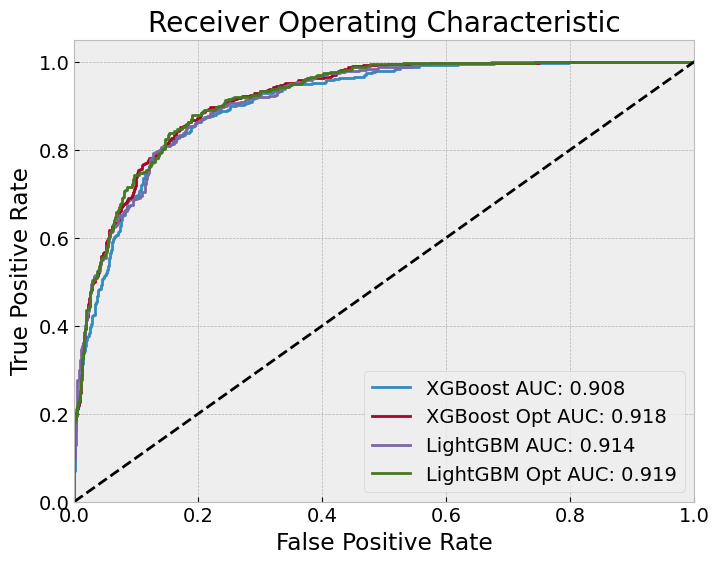

In [28]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, label='XGBoost AUC: {:.3f}'.format(auc_xgb))
plt.plot(fpr_xgb_opt, tpr_xgb_opt, label='XGBoost Opt AUC: {:.3f}'.format(auc_xgb_opt))
plt.plot(fpr_lgbm, tpr_lgbm, label='LightGBM AUC: {:.3f}'.format(auc_lgbm))
plt.plot(fpr_lgbm_opt, tpr_lgbm_opt, label='LightGBM Opt AUC: {:.3f}'.format(auc_lgbm_opt))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### Metrics

In [29]:
results = pd.DataFrame(results)
results

,Model,Accuracy,Precision,Recall,F1,AUC
0,XGBoost,0.848119,0.702020,0.743316,0.722078,0.908045
1,XGBoost Opt,0.825408,0.623077,0.866310,0.724832,0.918409
2,LightGBM,0.838893,0.660832,0.807487,0.726835,0.914175
3,LightGBM Opt,0.827537,0.628180,0.858289,0.725424,0.918980
